# Classifying Chess Pieces

*Why?  Somewhere between sudoku and go...* Sometimes I'm looking at a chess diagram on the web or in a book.  It might be a "White to move and checkmate in four" puzzle.  Trying to visualize the solution in my head is how I try to build "chess muscles."  If I try to solve the puzzle but don't understand the provided solution--"What if my opponent plays this move instead of that move on move three?"--I can create a "FEN" string that describes the position, and feed the FEN string to a chess computer program that can walk me through the variations.  But there doesn't seem to be a way to create this string directly from the image of a chess diagram.  I'm hoping that being able to differentiate the various chess pieces (king, queen, rook, bishop, knight, pawn) will be a good first step for me in being able to take a photo of a chess diagram on my phone and start analyzing the position in a chess engine.

## To consider

* Given our goal to create a FEN string, what other information do we need besides being able to identify the six chess pieces?
* Which chess pieces did the model have the most time telling apart?  How might this be improved?
* Describe how this specific kaggle dataset indicated image and labels.  What are other ways a vision dataset might indicate these?

![mate in 4!](https://catlin-607.s3.us-east-2.amazonaws.com/data/chess_diagram_workflow.png)

Resources:

Steps to download Kaggle datasets in Google Colab, https://www.kaggle.com/general/156610

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"catlin","key":"1072cbb0666adbcb510fa18b04a5dba6"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content/gdrive/MyDrive/Data


In [ ]:
!kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                        480KB  2023-01-04 12:50:31           3905        143  1.0              
senapatirajesh/netflix-tv-shows-and-movies                      Latest Netflix TV shows and movies                  1MB  2023-01-14 17:03:12            819         25  0.88235295       
thedevastator/global-fossil-co2-emissions-by-country-2002-2022  Emissions by Country, 2002-2022                   621KB  2023-01-02 20:10:36           1920         66  1.0              
johnny1994/divorce-rates-data-should-you-get-married            Divorc

In [ ]:
from fastai.vision.all import *

# get chess pieces data from kaggle

In [ ]:
!kaggle datasets download -d s4lman/chess-pieces-dataset-85x85

chess-pieces-dataset-85x85.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from fastcore.xtras import Path
zip_path = Path("chess-pieces-dataset-85x85.zip")
zip_path.exists()

True

In [ ]:
import zipfile
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("Data")

In [ ]:
!pwd

/content/gdrive/MyDrive/Data


In [ ]:
%cd /content/gdrive/MyDrive/Data

/content/gdrive/MyDrive/Data


In [ ]:
downloaded_path = Path('data')
resized_path = Path('chess_pieces')

In [ ]:
chess_pieces = []

for file in downloaded_path.iterdir():
  chess_pieces.append(file.stem)

print(chess_pieces)

['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']


In [ ]:
for piece in chess_pieces:
  resize_images(downloaded_path / piece, max_size = 64, dest = resized_path / piece)

In [ ]:
failed = verify_images(get_image_files(resized_path))
failed.map(Path.unlink)
len(failed)

0

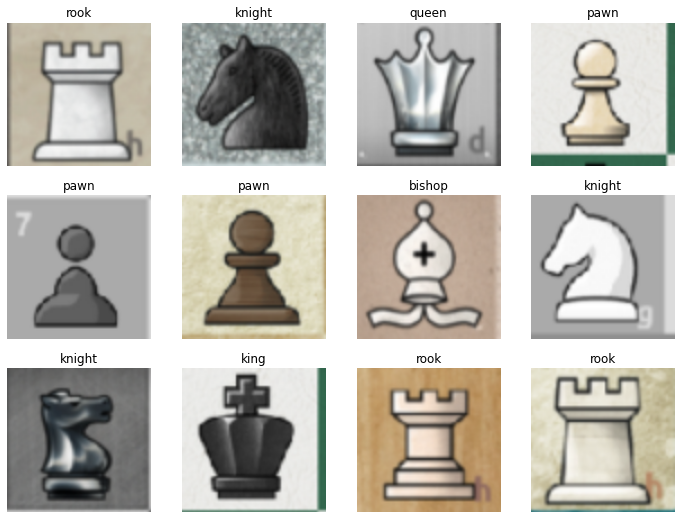

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128)]
).dataloaders(resized_path, bs=16)

dls.show_batch(max_n=12)

In [ ]:
dls.vocab

['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']

In [ ]:
dls.vocab.o2i

{'bishop': 0, 'king': 1, 'knight': 2, 'pawn': 3, 'queen': 4, 'rook': 5}

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.873419,0.326220,0.883495,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.334617,0.127906,0.970874,00:02
1,0.228538,0.107097,0.961165,00:02
2,0.192651,0.256377,0.922330,00:02
3,0.144888,0.159265,0.961165,00:02
4,0.122448,0.133227,0.961165,00:02


In [ ]:
test_path = Path('test_pieces')
king = test_path / "black_king.png"

In [ ]:
im = Image.open(king)
im.to_thumb(28,28)

In [ ]:
piece_name,tensor,probs = learn.predict(PILImage.create(king))
print(probs)
print(tensor.tolist())
print(piece_name)

TensorBase([1.4279e-06, 9.9908e-01, 6.1233e-08, 2.7322e-07, 9.1810e-04,
            8.9843e-07])
1
king


In [ ]:
test_path = Path('test_pieces')
bishop = test_path / "white_bishop.png"

In [ ]:
im = Image.open(bishop)
im.to_thumb(28,28)

In [ ]:
piece_name,_,probs = learn.predict(PILImage.create(bishop))
print(probs)
print(piece_name)
#print(f"This is a: {piece_name}.")
#print(f"Probability it's a {piece_name}: {probs[0]:.4f}")

TensorBase([0.8761, 0.0223, 0.0013, 0.0952, 0.0014, 0.0036])
bishop


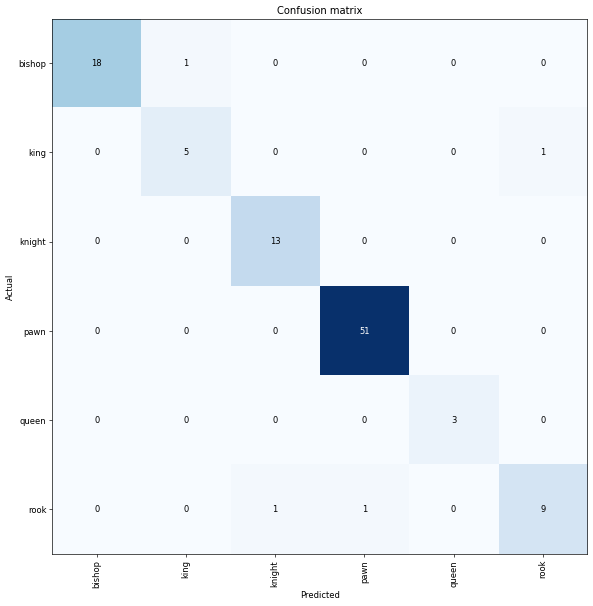

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [ ]:
interp.most_confused(min_val=1)

[('bishop', 'king', 1),
 ('king', 'rook', 1),
 ('rook', 'knight', 1),
 ('rook', 'pawn', 1)]

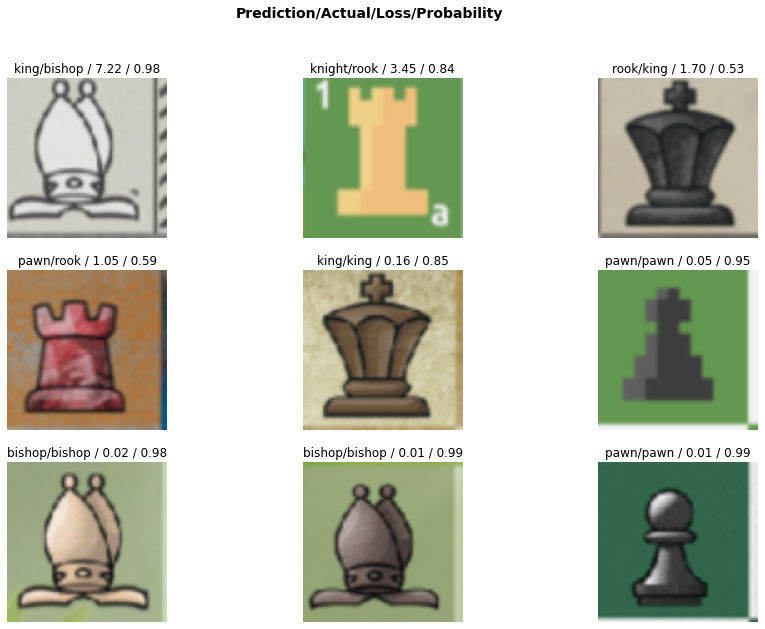

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

![mate in 4!](https://catlin-607.s3.us-east-2.amazonaws.com/data/chess_diagram_workflow.png)

## To consider

* Given our goal to create a FEN string, what other information do we need besides being able to identify the six chess pieces?
* Which chess pieces did the model have the most time telling apart?  How might this be improved?
* Describe how this specific kaggle dataset indicated image and labels.  What are other ways a vision dataset might indicate these?

